# <font color=blue>DETECCIÓN DE VALORES ATÍPICOS (OUTLIERS)</font>


---

## <font color=red>REQUISITOS:</font>

> El proceso de tratamiento de Outiliers en este cuaderno aplica la técnica de los "Cuartiles" para eliminar los valores atípicos.<br>
> El proceso de tratamiento de Outiliers NO trata valores nulos en este cuaderno.<br>
> El proceso de tratamiento de Outliers empieza después del tratamiento de valores nulos. <br>
> El proceso de tratamiento de Outliers que es aplicado en este cuaderno, lee un fichero CSV que ha sido tratado anteriormente. <br>
> El tratamiento de los tipos de datos (de cada columna) ya vienen tratado de etapas anteriores a este proceso.<br>

---

<font color=green>**--> Datos contenidos en el CSV:** </font>

_Datos de contaminantes atmosféricos y datos de eventos climáticos._

<font color=green>**--> Entrada del Proceso:** </font>

_archivo CSV calidad_aire_clean.csv_ (Considerase que el tratamiento de valores nulos ya viene tratado en este fichero)

<font color=green>**--> Salida del Proceso:** </font>

_archivo CSV calidad_aire_clean_outliers.csv_

<font color=green>**--> Técnica utilizada para la detección de outliers: Cuartiles** </font>

Cuartiles son medidas estadísticas de posición que a partir de valores (0,25; 0,50; 0,75) dividen un conjunto ordenado X en 4 partes iguales.
La técnica consiste en calcular el rango inter cuartil (IQR) obteniendo el límite inferior y superior.

Basandose en este rango es posíble identificar cuales son los valores atípicos y sacarlos de nuestra base de datos.

---


## <font color=pink>Importar librerías</font>


In [623]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from data_util import calcular_ICA

# Trabajar con imagenes
from IPython.display import display, HTML
import PIL.Image

## <font color=pink>Importar datos</font>


In [624]:
ruta = "../data/calidad_aire_clean.csv"
ruta_nuevoCSV = "../data/calidad_aire_clean_outliers.csv"
data = pd.read_csv(ruta, delimiter=",", engine="python")
data.head(2)

,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,...,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA
0,2019-01-01 00:00:00,2019.0,1.0,1.0,0,Martes,8.0,13.0,0.7,79.0,...,32.0,3.84,6.4,6.9,50.0,10.4,64.0,3.20,197.5,68.78
1,2019-01-01 01:00:00,2019.0,1.0,1.0,1,Martes,8.0,13.0,0.6,76.0,...,105.0,3.61,4.9,6.7,48.0,10.4,210.0,3.01,190.0,103.35


### Cantidad de datos importados


In [625]:
data.shape

(38256, 21)

### Identificación de los tipos de columnas


In [626]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        38256 non-null  object 
 1   ANO          38256 non-null  float64
 2   MES          38256 non-null  float64
 3   DIA          38256 non-null  float64
 4   HORA         38256 non-null  int64  
 5   DIA_SEMANA   38256 non-null  object 
 6   ESTACION     38256 non-null  float64
 7   SO2          38256 non-null  float64
 8   CO           38256 non-null  float64
 9   NO2          38256 non-null  float64
 10  PM2.5        38256 non-null  float64
 11  PM10         38256 non-null  float64
 12  O3           38256 non-null  float64
 13  BTX          38256 non-null  float64
 14  TEMPERATURA  38256 non-null  float64
 15  HUMEDAD      38256 non-null  float64
 16  ICA_SO2      38256 non-null  float64
 17  ICA_PM10     38256 non-null  float64
 18  ICA_O3       38256 non-null  float64
 19  ICA_

## <font color=pink>Estadísticas Descriptiva</font>


In [627]:
data.describe().round(0)

,ANO,MES,DIA,HORA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA
count,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0,38256.0
mean,2021.0,6.0,16.0,12.0,8.0,5.0,0.0,38.0,10.0,19.0,49.0,3.0,16.0,55.0,4.0,38.0,41.0,96.0,45.0
std,1.0,3.0,9.0,7.0,0.0,3.0,0.0,25.0,8.0,16.0,29.0,4.0,8.0,22.0,3.0,31.0,24.0,62.0,18.0
min,2019.0,1.0,1.0,0.0,8.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,-30.0,0.0,0.0,2.0,1.0,8.0,13.0
25%,2020.0,3.0,8.0,6.0,8.0,2.0,0.0,20.0,4.0,9.0,27.0,1.0,10.0,37.0,2.0,18.0,22.0,50.0,32.0
50%,2021.0,6.0,16.0,12.0,8.0,4.0,0.0,33.0,8.0,16.0,49.0,2.0,15.0,54.0,3.0,32.0,41.0,82.0,41.0
75%,2022.0,9.0,23.0,17.0,8.0,8.0,0.0,51.0,13.0,24.0,67.0,4.0,22.0,72.0,6.0,48.0,56.0,128.0,53.0
max,2023.0,12.0,31.0,23.0,8.0,35.0,3.0,279.0,106.0,322.0,181.0,151.0,42.0,100.0,28.0,644.0,151.0,698.0,253.0


In [628]:
data.shape

(38256, 21)

### Verificar si hay valores nulos no tratados


In [629]:
data.isnull().sum()

FECHA          0
ANO            0
MES            0
DIA            0
HORA           0
DIA_SEMANA     0
ESTACION       0
SO2            0
CO             0
NO2            0
PM2.5          0
PM10           0
O3             0
BTX            0
TEMPERATURA    0
HUMEDAD        0
ICA_SO2        0
ICA_PM10       0
ICA_O3         0
ICA_NO2        0
ICA            0
dtype: int64

## <font color=pink>Análisis Exploratória - Valores Atípico (Outliers)</font>

Empezamos por analisar si hay valores atípico en nuestro conjunto de datos y luego identificamos por medio de las gráficas de bigotes (BoxPlot), cuales son los valores que estan fuera del Rango Intercuartil".

Para esto, seleccionamos las columnas (variables) que iremos trabajar:

\*\* Contaminantes (Cualidad del Aire)
<font color=orange>- 'SO2', 'CO', 'NO2', 'PM2.5', 'PM10', 'O3', 'BTX'</font>

\*\* Eventos climáticos (Meteorología)
<font color=orange>- 'TEMPERATURA', 'HUMEDAD'</font>


In [630]:
# funcion que dado un determinado dataframe genera una tabla con los valores de parámetros de Cuartiles que vamos aplicar en el
# tramamiento de Outiers.
def calcular_estadisticas(df):
    # Crear un nuevo DataFrame para almacenar los resultados de los cuartiles
    resultados_df = pd.DataFrame(
        columns=[
            "Columna",
            "Cuartil 0.25",
            "Cuartil 0.50",
            "Cuartil 0.75",
            "Rango intercuartil"
        ]
    )

    # Crea una lista con las variables que queremos verificar los cuartiles
    numeric_columns = [
        "SO2",
        "CO",
        "NO2",
        "PM2.5",
        "PM10",
        "O3",
        "BTX",
        "TEMPERATURA",
        "HUMEDAD"
    ]

    # Calcular los cuartiles y los rangos intercuartiles para cada columna
    for columna in numeric_columns:
        Q1 = df[columna].quantile(0.25)
        Q2 = df[columna].quantile(0.50)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        new_row = pd.DataFrame(
            {
                "Columna": columna,
                "Cuartil 0.25": Q1,
                "Cuartil 0.50": Q2,
                "Cuartil 0.75": Q3,
                "Rango intercuartil": IQR,
                "Limite inferior": limite_inferior,
                "Limite superior": limite_superior,
            },
            index=[0]
        )

        resultados_df = pd.concat([resultados_df, new_row], ignore_index=True)

    # retorna un nuevo DataFrame (resultados_df) con los resultados
    return resultados_df.head(15).round(2)

In [631]:
%%time 
# LLama la función para conocernos los valores de los parámetros del procesos de los cuartiles que iremos aplicar a 
# nuestro conjunto de datos. Esta tabla tambien sirve para la documentación del proyecto.
calcular_estadisticas(data)

CPU times: total: 62.5 ms
Wall time: 61 ms


,Columna,Cuartil 0.25,Cuartil 0.50,Cuartil 0.75,Rango intercuartil,Limite inferior,Limite superior
0,SO2,2.00,4.00,8.0,6.00,-7.00,17.00
1,CO,0.20,0.30,0.3,0.10,0.05,0.45
2,NO2,20.00,33.00,51.0,31.00,-26.50,97.50
3,PM2.5,4.00,8.00,13.0,9.00,-9.50,26.50
4,PM10,9.00,16.00,24.0,15.00,-13.50,46.50
5,O3,26.86,48.66,67.0,40.14,-33.36,127.21
6,BTX,1.20,2.20,3.9,2.70,-2.85,7.95
7,TEMPERATURA,10.00,15.20,22.0,12.00,-8.00,40.00
8,HUMEDAD,37.00,54.00,72.0,35.00,-15.50,124.50


### Gráficas (Situación Actual)

#### Diagrama de Caja y Bigotes (BoxPlot)

In [632]:
html2 = '<div style="display: flex; justify-content: center;"><img src="..\imagenes\ComprendiendoBoxPlots.png" style="width: 65%; height: auto;"></div>'
HTML(html2)

In [633]:
# Genera la gráfica de Bigote con todas las variables juntas
def generar_grafica_boxplot(dataframe):
    # Definir el tamaño de la figura
    plt.figure(figsize=(12, 8))  # ancho/alto

    # Configuración del layout de la gráfica
    plt.grid(True)  # Mostrar cuadrícula
    plt.xticks(rotation=45)  # Rotar etiquetas del eje x
    # plt.yticks(rotation=45)   # Rotar etiquetas del eje y
    plt.yticks(range(0, 301, 30))  # Rango de valores en el eje y
    plt.rcParams.update({"font.size": 10})  # Cambiar tamaño de la fuente

    # Código para generar la gráfica
    boxplot = dataframe.boxplot(
        column=[
            "SO2",
            "CO",
            "NO2",
            "PM2.5",
            "PM10",
            "O3",
            "BTX",
            "TEMPERATURA",
            "HUMEDAD",
        ],
        return_type="axes",
        showmeans=True
    )
    return boxplot

CPU times: total: 438 ms
Wall time: 520 ms


matplotlib.axes._axes.Axes

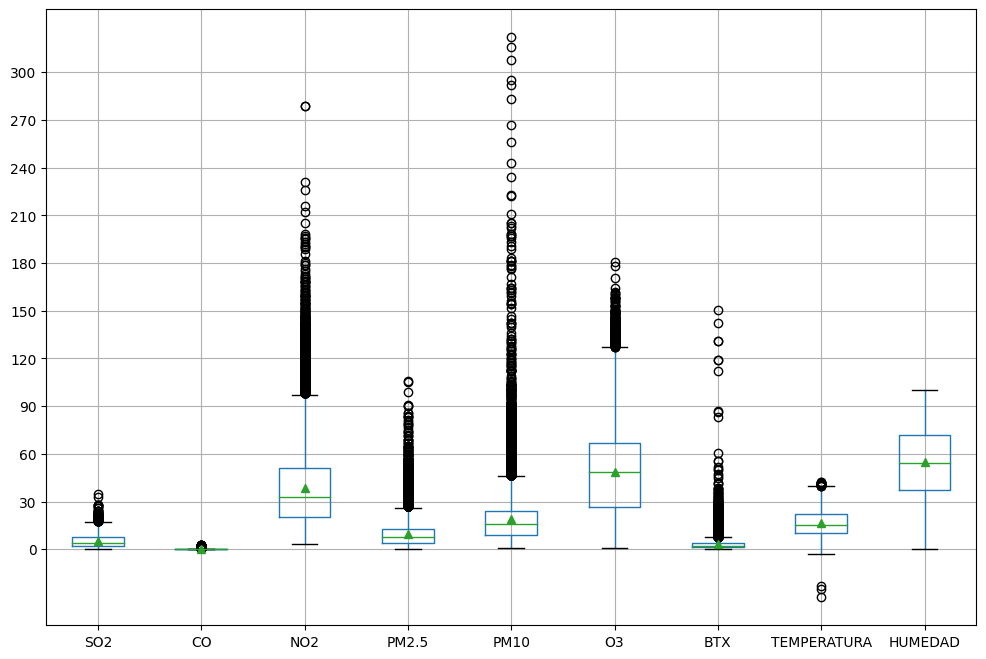

In [634]:
%%time 
# Llamada a la función
grafica = generar_grafica_boxplot(data)
type(grafica)

#### Diagrama de Caja y Bigotes (BoxPlot) generado individualmente para cada columna (variable)


In [635]:
# Define una función llamada "plot_boxplot"

# Crea el diagram de caja y bigote
def plot_boxplot(dataframe, columna):
    fig, ax = plt.subplots()
    
    # Crea la gráfica boxplot
    ax.boxplot(dataframe[columna])
    
    # Función que ajusta los valores en el eje "Y" para que todas las gráficas presenten el mismo valore en este eje.
    # ax.set_ylim(0, 120)
    # ax.set_yticks(range(0, 100, 15))
    # plt.show()
    
    # Elimina las líneas de cuadrícula
    plt.grid(False)

    # Apresenta la gráfica en pantalla
    plt.show()

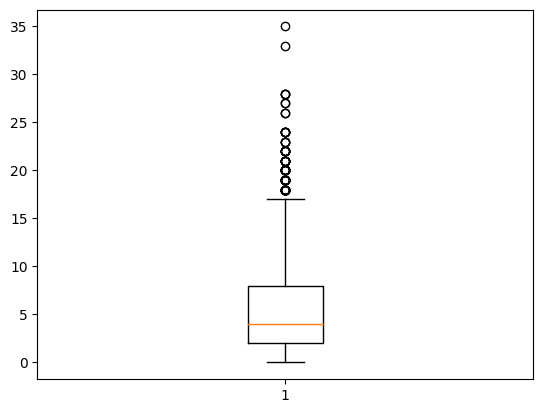

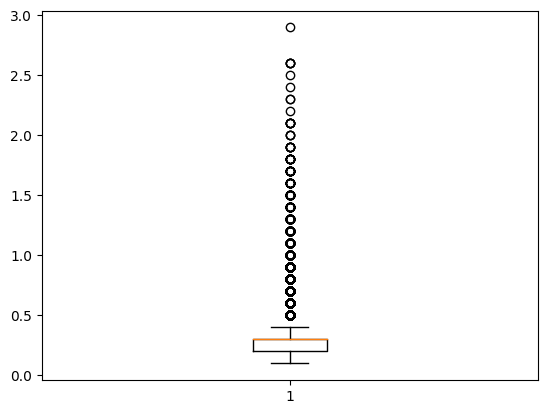

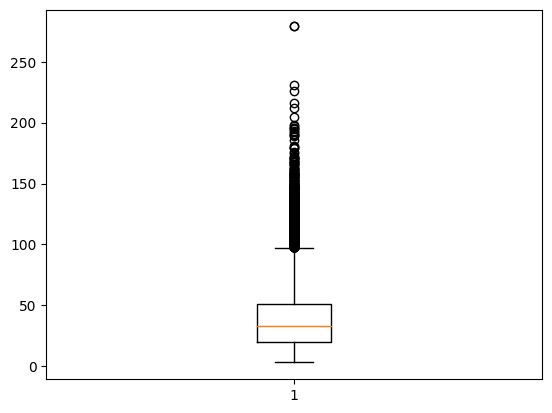

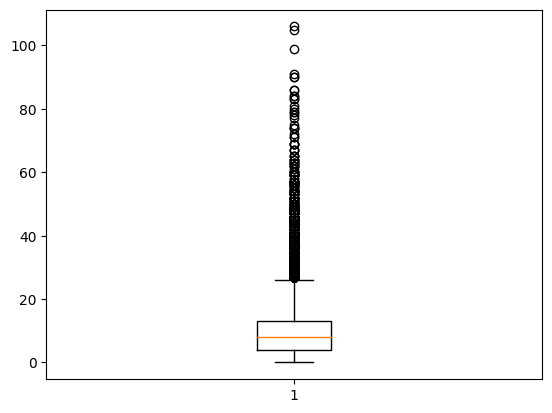

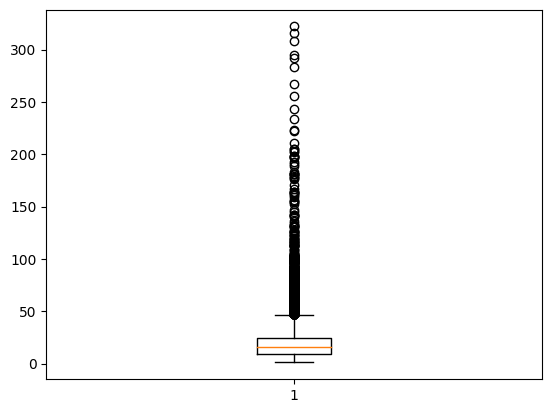

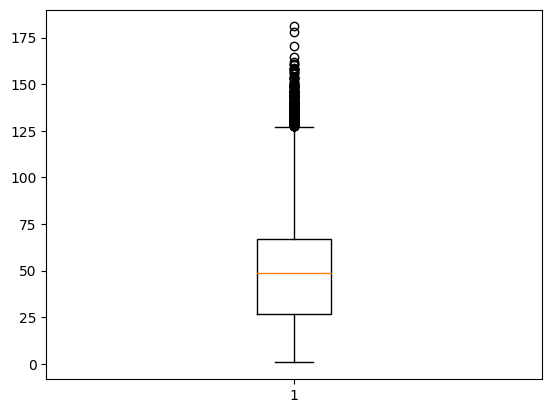

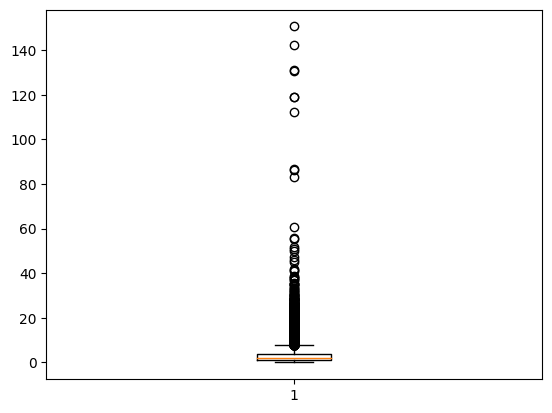

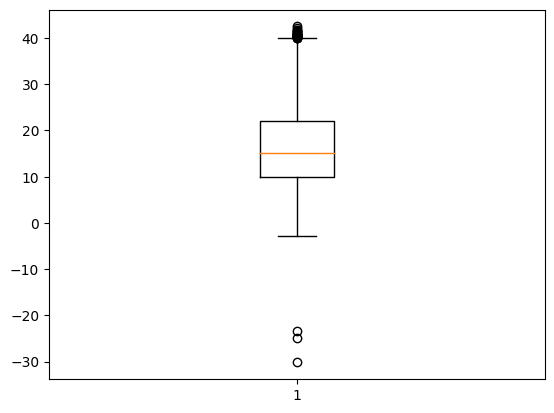

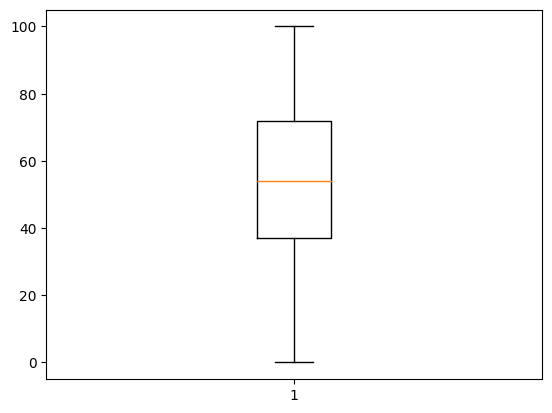

In [636]:
plot_boxplot(data, "SO2")
plot_boxplot(data, "CO")
plot_boxplot(data, "NO2")
plot_boxplot(data, "PM2.5")
plot_boxplot(data, "PM10")
plot_boxplot(data, "O3")
plot_boxplot(data, "BTX")
plot_boxplot(data, "TEMPERATURA")
plot_boxplot(data, "HUMEDAD")

## <font color=pink>Elimina Outliers - Empieza el proceso de limpieza de los valores atípicos</font>


In [637]:
# Define una función llamada "outliers" que devuelve una lista de valores atípicos basados em el IQR
# IQR = Q3 - Q1
# +/- 1.5*IQR

def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    ls = df.index[(df[ft] < limite_inferior) | (df[ft] > limite_superior)]

    return ls

In [638]:
%%time 
# Busca y recopila los índices de los valores atípicos (outliers) en las columnas especificadas del conjunto de datos "data"

# crea una lista vacía para almacenar los índices
index_list = []
for column in [
    "SO2",
    "CO",
    "NO2",
    "PM2.5",
    "PM10",
    "O3",
    "BTX",
    "TEMPERATURA",
    "HUMEDAD"
]:
    index_list.extend(outliers(data, column))


CPU times: total: 46.9 ms
Wall time: 44 ms


In [639]:
# Define una función que devuelve un dataframe (marco de datos) limpio, sin valores atípicos
def eliminar(df, columna):
    columna = sorted(set(columna))
    df = data.drop(columna)
    return df

In [640]:
%%time 
data_limpio = eliminar(data, index_list)
data_limpio.head(2)

CPU times: total: 15.6 ms
Wall time: 10 ms


,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,...,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA
5,2019-01-01 05:00:00,2019.0,1.0,1.0,5,Martes,8.0,10.0,0.4,50.0,...,19.0,11.88,2.6,4.7,50.0,8.0,38.0,9.90,125.0,45.22
6,2019-01-01 06:00:00,2019.0,1.0,1.0,6,Martes,8.0,8.0,0.4,55.0,...,16.0,7.97,2.2,3.2,55.0,6.4,32.0,6.64,137.5,45.64


In [641]:
data_limpio.shape
# Habian en el dataframe original "data" 30.240 registros, despues de la limpeza de los outliers, 
# este valor se ha bajado a 26.321.

(30860, 21)

### Gráficas (Después del proceso de limpeza de los Outliers)


CPU times: total: 328 ms
Wall time: 336 ms


matplotlib.axes._axes.Axes

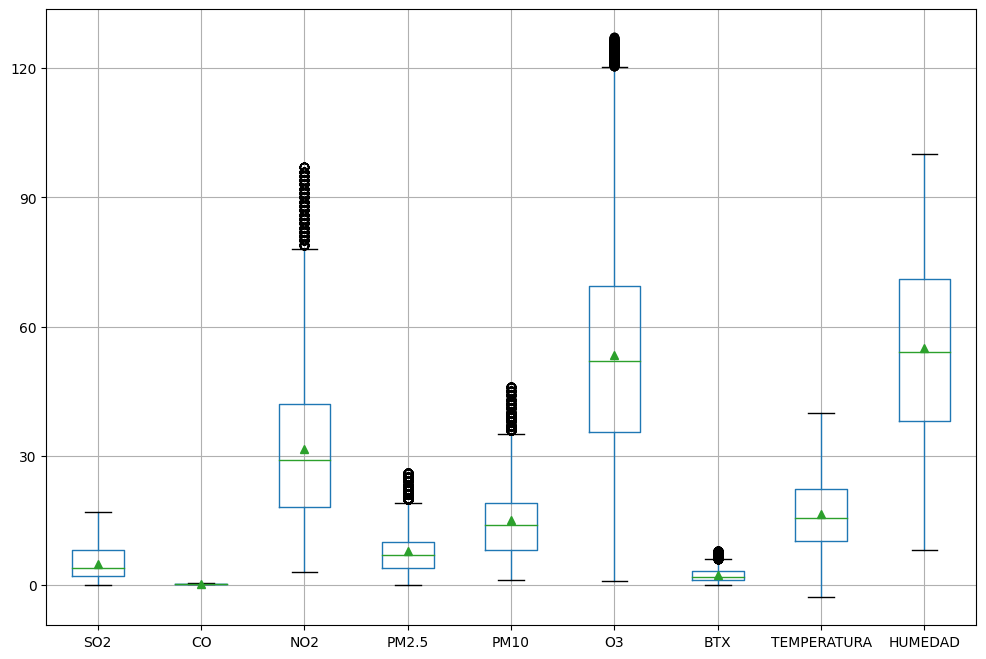

In [642]:
%%time 
# Llamada a la función
grafica = generar_grafica_boxplot(data_limpio)
type(grafica)

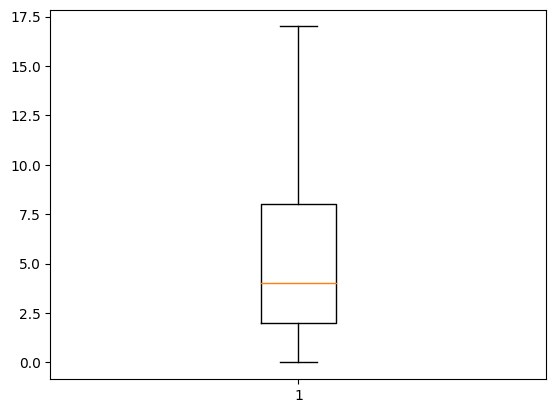

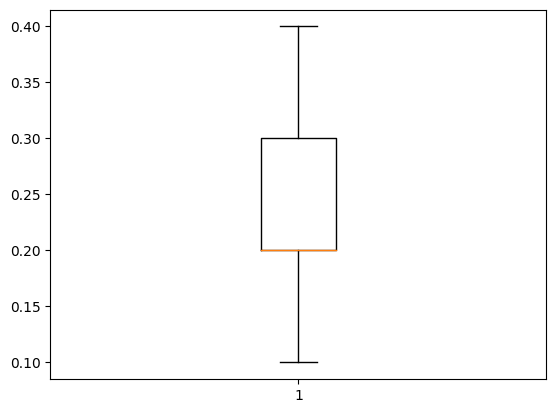

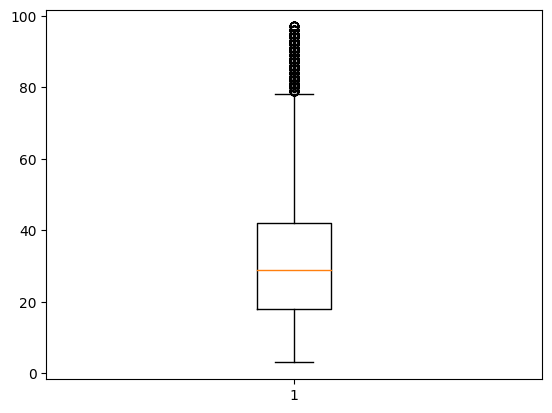

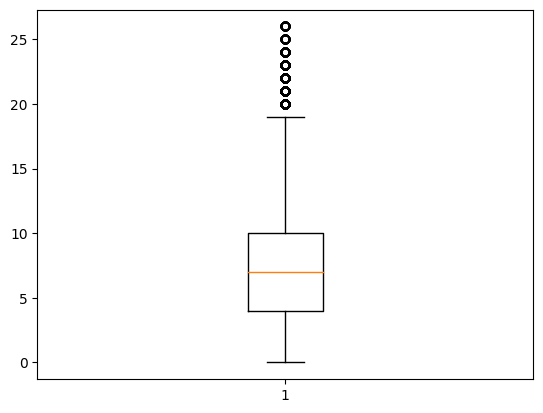

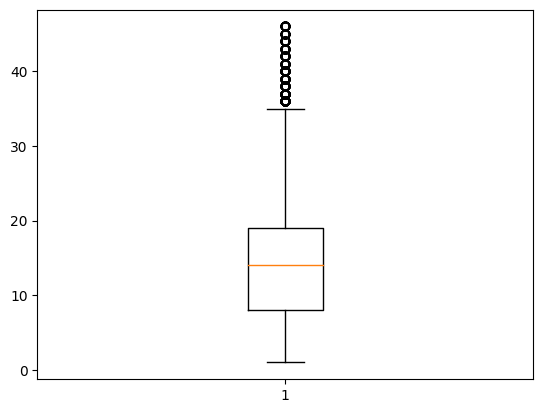

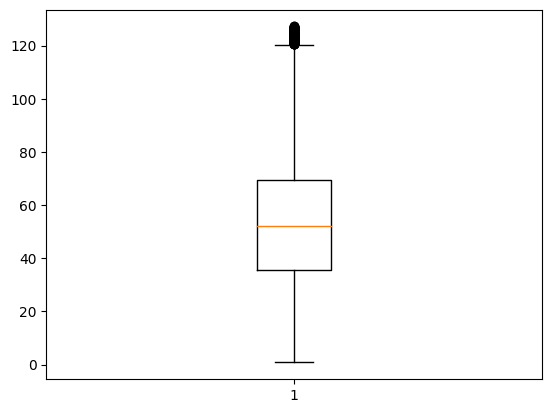

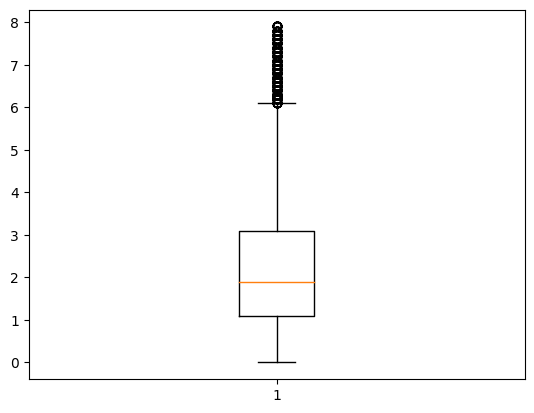

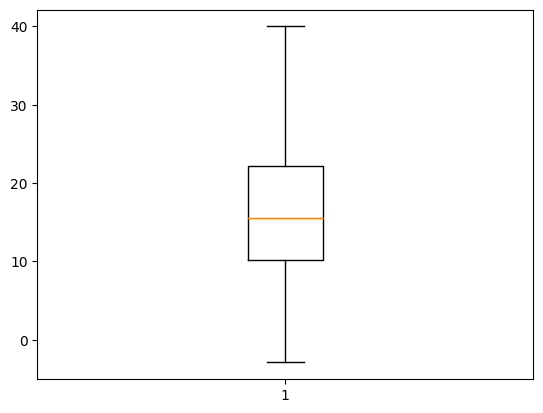

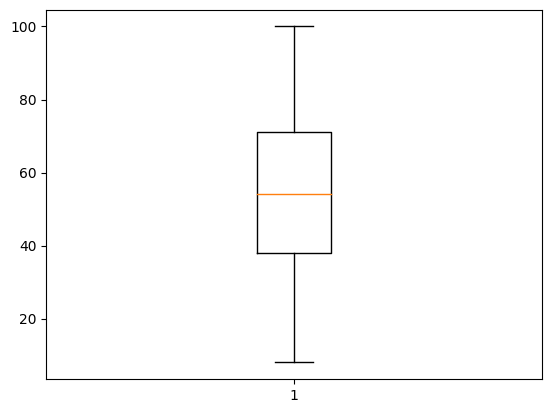

In [643]:
plot_boxplot(data_limpio, "SO2")
plot_boxplot(data_limpio, "CO")
plot_boxplot(data_limpio, "NO2")
plot_boxplot(data_limpio, "PM2.5")
plot_boxplot(data_limpio, "PM10")
plot_boxplot(data_limpio, "O3")
plot_boxplot(data_limpio, "BTX")
plot_boxplot(data_limpio, "TEMPERATURA")
plot_boxplot(data_limpio, "HUMEDAD")

## <font color=pink>Genera nuevo csv con los datos limpios</font>


In [644]:
%%time 
data_limpio.to_csv(ruta_nuevoCSV, index=False)

CPU times: total: 500 ms
Wall time: 493 ms
